<a href="https://colab.research.google.com/github/vilcagamarracf/Inv_arroz_METRIC/blob/main/notebooks/1_Visualizaci%C3%B3n_de_Im%C3%A1genes_en_Earth_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p> Primera Libreta sobre el trabajo de investigación: </p>

<center>

<p> 
<b>
"Estimación de la evapotranspiración espacio-temporal en arrozales usando imágenes satelitales, Departamento de Lambayeque" 
</b>
</p>

</center>

Autor: Cesar Vilca

Marzo, 2022

# 1. Visualización de Imágenes en Earth Engine

## Inicio

##### Credenciales de Earth Engine

In [1]:
# # Ingresa tus credenciales de Google Earth Engine para comenzar
# import ee
# ee.Authenticate()

# # Inicio
# ee.Initialize()

# # Mensaje de login
# print('\nYa estás logeado.')
# print('GEE Version:', ee.__version__)

In [2]:
#@markdown *Credenciales Google Earth Engine: Forma rápida*
import os 
credential = '{"refresh_token":"1//09lhqedCNpNDsCgYIARAAGAkSNwF-L9IraEP8FyJma46WSiEHhOMsZqSoTPJsi3Lar0C4nZUwj2QCZ_i66-McVzy4NmMalQL17KM"}'
credential_file_path = os.path.expanduser("~/.config/earthengine/")
os.makedirs(credential_file_path,exist_ok=True)
with open(credential_file_path + 'credentials', 'w') as file:
    file.write(credential)
import ee
ee.Initialize()
print('Ya estás logeado.')
print('GEE Version:',ee.__version__)

Ya estás logeado.
GEE Version: 0.1.303


##### geemap

Documentación `geemap`
- [geemap - key features](https://geemap.org/notebooks/00_geemap_key_features/)

In [3]:
# Instalar geemap
%%capture
!pip install -U geemap # Nota: Con la actualización de ipyleaflet v0.15.0 se produjo un conflicto con geemap
# !pip install geemap==0.10.1

In [ ]:
import geemap
# import geemap.eefolium as geemap
Map = geemap.Map(basemap='HYBRID', center=(-9.125, -74.396), zoom=5) # basemap='HYBRID', 'OpenStreetMap.Mapnik' 

# Descomentar la siguiente línea para visualizar 
# Map

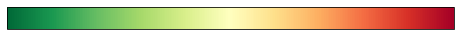

In [10]:
import geemap.colormaps as cm # Paletas para visualización de imágenes

# cm.list_colormaps()
# cm.plot_colormaps(width=12, height=0.4)

# Establecer una paleta
paleta = cm.palettes.RdYlGn_r

# Ver una paleta
cm.plot_colormap('RdYlGn_r', width=8.0, height=0.4, orientation='horizontal')

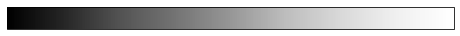

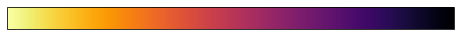

In [ ]:
cm.plot_colormap('Greys_r', width=8.0, height=0.4, orientation='horizontal')
cm.plot_colormap('inferno_r', width=8.0, height=0.4, orientation='horizontal')

##### Funciones

In [5]:
# Mejorar visibilidad de tablas en Colab
%load_ext google.colab.data_table

# Para volver al estado original de las tablas
# %unload_ext google.colab.data_table

In [6]:
# Funciones usadas en Inv-Arroz-METRIC
import pandas as pd
from ipywidgets import interact, fixed

from dateutil.relativedelta import relativedelta # Incrementar fecha en meses

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates # Modificar fechas por formato
date_format = mpl_dates.DateFormatter('%Y-%m')

In [7]:
# @markdown Función `generar_reporte(icol)`

def generar_reporte(icol):

  """Generar reportes para ee.ImageCollection 's
  
  A partir de un ee.ImageCollection devolver una tabla 
  con información de ID, Fechas (Año, Mes, Día, Día Juliano) y 
  propiedades como Ángulo Zenital y Porcentaje de Nubosidad.

  Argumentos:
  - icol : ee.ImageCollection
  Retorna:
  - pandas.Dataframe
  """

  ## Generando campos para la tabla
  ID_snippet_name = icol.get('system:id').getInfo()

  # Lista con fechas UTC+00 (en milisegundos)
  lista_fechas = icol.aggregate_array('system:time_start').getInfo()

  # Lista con ID's
  imgCol_ids = icol.aggregate_array('system:id').getInfo() # ID

  # Armando dataframe
  df = pd.DataFrame(lista_fechas, columns = ['millis'])

  df["ID GEE"] = imgCol_ids
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms') - pd.DateOffset(hours=5) # UTC-5
  df['Fecha Precisa'] = pd.DatetimeIndex(df['Timestamp']) # Con hora
  df['Fecha Corta'] = pd.DatetimeIndex(df['Timestamp']).date
  df['Año'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Mes'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Día'] = pd.DatetimeIndex(df['Timestamp']).day
  # df['Hora'] = pd.DatetimeIndex(df['Timestamp']).hour
  df['Día Juliano'] = pd.DatetimeIndex(df['Timestamp']).dayofyear

  l_icols_id = ['LANDSAT/LC08/C01/T1','LANDSAT/LC08/C02/T1', 'LANDSAT/LC08/C02/T1_TOA', 
                'LANDSAT/LC09/C02/T1','LANDSAT/LC09/C02/T1_L2', 'LANDSAT/LC09/C02/T1_TOA',
                'LANDSAT/LC09/C02/T1_RT_TOA',
                'LANDSAT/LE07/C02/T1', 'LANDSAT/LE07/C02/T1_TOA',
                'LANDSAT/LT05/C01/T1_TOA', 'LANDSAT/LM05/C01/T1']

  l_icols_sr_id = ['LANDSAT/LT05/C02/T1_L2','LANDSAT/LC08/C02/T1_L2',
                   'LANDSAT/LE07/C02/T1_L2']

  # Agregando propiedades
  if ID_snippet_name == 'LANDSAT/LC08/C01/T1_SR':
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()
    df['SOLAR_ZENITH_ANGLE'] = icol.aggregate_array('SOLAR_ZENITH_ANGLE').getInfo()

  elif ID_snippet_name in l_icols_id:
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()
    df['CLOUD_COVER'] = df['CLOUD_COVER'].round(decimals=3)
    df['SUN_ELEVATION'] = icol.aggregate_array('SUN_ELEVATION').getInfo()

  elif ID_snippet_name in l_icols_sr_id:
    df['CLOUD_COVER'] = icol.aggregate_array('CLOUD_COVER').getInfo()
    df['SUN_ELEVATION'] = icol.aggregate_array('SUN_ELEVATION').getInfo()
    df['ZENITH ANGLE'] = 90. - df['SUN_ELEVATION']
    df['ZENITH ANGLE'] = df['ZENITH ANGLE'].round(decimals=7)
    df = df.drop(columns=['SUN_ELEVATION'])

  elif ID_snippet_name == 'COPERNICUS/S2_SR':
    df['MEAN_SOLAR_ZENITH_ANGLE'] = icol.aggregate_array('MEAN_SOLAR_ZENITH_ANGLE').getInfo()
    df['CLOUDY_PIXEL_PERCENTAGE'] = icol.aggregate_array('CLOUDY_PIXEL_PERCENTAGE').getInfo()
  
  df = df.drop(columns=['millis', 'Timestamp'])
  # df.to_csv('datos_2020_L8_SR.csv')
  
  return df

In [8]:
# @markdown Función `ver_imgs_mensual(mes, df, snippet_name, roi)`

def ver_imgs_mensual(mes, df, snippet_name, roi):
  """Visualizar imágenes a partir del reporte generado con la función generar_reporte
  
  Argumentos:
  - mes : lista de valores [1,2,3] del 1 al 12 que representen los meses
  - df : pandas.DataFrame con columna 'ID GEE' de ID's 
  - roi : ee.geometry o ee.FeatureCollection 
  Retorna:
  - ee.Image

  Usarse con interact
  """
  # Del dataframe obtenemos las imagenes de acuerdo al mes que queramos
  lista_imagenes = df[df['Mes'] == mes]['ID GEE'].tolist()

  # Parametros de visualización RGB
  bands = ['B4', 'B3', 'B2']
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands}# 'gamma':1.4
  
  # Visualización
  # import geemap.eefolium as geemap
  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik', 
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)

  icol_t1 = ['LANDSAT/LC08/C01/T1', 'LANDSAT/LC08/C02/T1', 
             'LANDSAT/LC09/C02/T1']
                 
  icol_t1_l2 = ['LANDSAT/LC08/C02/T1_L2', 
                'LANDSAT/LC09/C02/T1_L2']

  icol_le07_lt05 = ['LANDSAT/LT05/C02/T1_L2', 
                    'LANDSAT/LE07/C02/T1_L2']

  icol_toa = ['LANDSAT/LC08/C02/T1_TOA',
              'LANDSAT/LC09/C02/T1_TOA']

  # Sentinel-2
  if snippet_name == 'COPERNICUS/S2_SR':
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0001)                 
      Map.addLayer(image, vis_rgb, f'Imagen {i}')

  # Landsat 5, 7, 8 y 9
  elif snippet_name == 'LANDSAT/LC08/C01/T1_SR':
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0001)
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  elif snippet_name in icol_t1:
    for i in lista_imagenes:
      image = ee.Image(i)
      vis_rgb = {'min': 0.0, 'max': 30000, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'{i[:12]} - {i[-4:-2]}/{i[-2:]}')

  elif snippet_name in icol_toa:
    for i in lista_imagenes:
      image = ee.Image(i)
      vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  elif snippet_name in icol_t1_l2:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0000275).add(-0.2)
      bands = ['SR_B4', 'SR_B3', 'SR_B2']
      vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands} 
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')
  
  elif snippet_name in icol_le07_lt05:
    for i in lista_imagenes:
      image = ee.Image(i).multiply(0.0000275).add(-0.2)
      bands = ['SR_B3', 'SR_B2', 'SR_B1']
      vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  elif snippet_name == 'LANDSAT/LE07/C02/T1_TOA':
    for i in lista_imagenes:
      image = ee.Image(i)
      bands = ['B3', 'B2', 'B1']
      vis_rgb = {'min': 0.0, 'max': 0.4, 'gamma': 1.2, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')

  elif snippet_name == 'LANDSAT/LE07/C02/T1':
    for i in lista_imagenes:
      image = ee.Image(i)
      bands = ['B3', 'B2', 'B1']
      vis_rgb = {'min': 0.0, 'max': 300, 'gamma': 1.2, 'bands': bands}
      Map.addLayer(image, vis_rgb, f'Imagen {i[-4:-2]}/{i[-2:]}')
  
  # ROI
  empty = ee.Image().paint(roi, 3,5) # https://github.com/google/earthengine-api/blob/6445cae4c371a8244f70ae08c01a6da05dbc4c7d/python/examples/py/FeatureCollection/from_polygons.py
  Map.addLayer(empty, {}, 'ROI')

  return Map

In [9]:
# @markdown Función `maskS2clouds(image)` para enmascarar nubes en imágenes Sentinel-2

## Operadores de bit a bit
# Operador bit a bit desplazamiento a la izquierda <<
# Little indian (los bits se cuentan de izq a derecha) y Big indian (los bits se cuentan de derecha a izq)
def maskS2clouds(image):
  qa = image.select('QA60')
  opaque_cloud = 1 << 10
  cirrus_cloud = 1 << 11
  mask = (
      qa.bitwiseAnd(opaque_cloud).eq(0)
      .And(qa.bitwiseAnd(cirrus_cloud).eq(0))
  )
  clean_image = (
      image.updateMask(mask)
      .divide(10000)
      .copyProperties(image, ["system:time_start"])
  )
  return clean_image

## Assets: Departamentos, Provincias y Distritos

### Selección de Distrito

Assets personales con datos vectoriales del Instituto Geográfico Nacional [IGN](https://www.idep.gob.pe/#visor):
- Departamentos: `'users/CesarVilca/departamentos'`
- Provincias: `'users/CesarVilca/provincias'`
- Distritos: `'users/CesarVilca/distritos'`

In [11]:
# @markdown **Assets**: Departamentos, Provincias y Distritos

# @markdown Distrito seleccionado

# Ejemplo de filtrado

# Assets
asset_dept = ee.FeatureCollection('users/CesarVilca/departamentos')
asset_prov = ee.FeatureCollection('users/CesarVilca/provincias')
asset_dist = ee.FeatureCollection('users/CesarVilca/distritos')

# Filtrado
deptSelectedName = 'LAMBAYEQUE'
provSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHICLAYO'
distSelectedName = 'FERREÑAFE' # 'FERREÑAFE' 'CHONGOYAPE'

dept_fcol = asset_dept.filterMetadata('DEPARTAMEN', 'equals', deptSelectedName)
prov_fcol = asset_prov.filterMetadata('PROVINCIA', 'equals', provSelectedName)
dist_fcol = asset_dist.filterMetadata('DISTRITO', 'equals', distSelectedName)

# ROI Caja
roi = dist_fcol.geometry().bounds()

empty = ee.Image().paint(dist_fcol, 2,2)
empty2 = ee.Image().paint(roi, 2, 2)

# Visualización
Map = geemap.Map(layer_ctrl = True) 
Map.centerObject(dist_fcol, 9)

Map.addLayer(dept_fcol, {'color':'red'}, f'Departamento {deptSelectedName}')
Map.addLayer(prov_fcol, {'color':'green'}, f'Provincia {provSelectedName} ')
Map.addLayer(dist_fcol, {'color':'blue'}, f'Distrito {distSelectedName}')

# Bordes
Map.addLayer(empty , {}, 'Distrito Seleccionado')
Map.addLayer(empty2, {}, 'Limites')

Map

# Zona de evaluación: Inicio Chongoyape
# parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape")
# parcelas_chongoyape.geometry().centroid().coordinates().getInfo()

Map(center=[-6.6205221157277006, -79.79111975903714], controls=(WidgetControl(options=['position', 'transparen…

### Área de estudio

In [ ]:
# Descargar ROI de GitHub
%%capture
!wget https://github.com/vilcagamarracf/Inv_arroz_METRIC/raw/main/files/zip/Ferre%C3%B1afe_areas.zip
!unzip Ferreñafe_areas.zip

In [ ]:
ruta_ferrenafe = r'/content/Ferreñafe_areas.shp'

predios_agricolas = geemap.shp_to_ee(ruta_ferrenafe)
predios_vis = ee.Image().paint(predios_agricolas, 1, 1)

predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1)

type(predios_agricolas)

ee.featurecollection.FeatureCollection

## Visualizaciones

Filtrado:
- Para imágenes Landsat se filtrará por PATH y ROW https://www.geogpsperu.com/2016/02/ubica-el-path-y-row-de-tu-distrito-para.html
  - En la parte final de esta sección se encuentra un ejemplo de filtrado con un `ee.Geometry` (abarca 2 o más ImageCollection)
- Para imágenes Sentinel-2 se filtrará por el distrito (`ee.Geometry`) seleccionado en la sección Assets

In [49]:
# Filtrado
path = 10
row = 65 # 64

fecha = '2021-12'
meses = 6

### Landsat

Landsat Collections in [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/landsat)

#### USGS Landsat 9 

##### USGS Landsat 9 Collection 2 Tier 1 Raw Scenes - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1)

In [ ]:
snippet_name = 'LANDSAT/LC09/C02/T1'

icol = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL9_raw = generar_reporte(icol)
reporteL9_raw

# Guardar dataframe
# reporteL8_RAW.to_csv('reporteL9_raw.csv', index=False, encoding='utf-8-sig')

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LC09/C02/T1/LC09_010065_20211212,2021-12-12 10:28:36.901,2021-12-12,2021,12,12,346,46.70,60.112699
1,LANDSAT/LC09/C02/T1/LC09_010065_20211228,2021-12-28 10:28:35.288,2021-12-28,2021,12,28,362,83.58,58.451368
2,LANDSAT/LC09/C02/T1/LC09_010065_20220113,2022-01-13 10:28:31.598,2022-01-13,2022,1,13,13,32.94,57.699672
3,LANDSAT/LC09/C02/T1/LC09_010065_20220129,2022-01-29 10:28:34.396,2022-01-29,2022,1,29,29,21.12,57.843961
4,LANDSAT/LC09/C02/T1/LC09_010065_20220214,2022-02-14 10:28:30.097,2022-02-14,2022,2,14,45,88.04,58.557032
5,LANDSAT/LC09/C02/T1/LC09_010065_20220302,2022-03-02 10:28:18.905,2022-03-02,2022,3,2,61,79.20,59.298935
6,LANDSAT/LC09/C02/T1/LO09_010065_20220318,2022-03-18 10:28:18.136,2022-03-18,2022,3,18,77,24.91,59.452818


In [ ]:
# @markdown Visualización con Plotly

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL9_raw['Fecha Precisa'], 
               y=reporteL9_raw['CLOUD_COVER'],
               name=f'{snippet_name}', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = f'Imágenes {snippet_name}'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)], 
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0),
    legend=dict(x=0.4, y=1.10),
    legend_orientation='h',
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )
    

fig.show()

In [ ]:
df_reporte = reporteL9_raw

# Visualizar imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name=fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3), value=12), Output()), _dom_classes=('…

##### USGS Landsat 9 Collection 2 Tier 1 TOA Reflectance - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_TOA)

In [ ]:
snippet_name = 'LANDSAT/LC09/C02/T1_TOA'

icol = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL9_toa = generar_reporte(icol)
reporteL9_toa

# Guardar dataframe
# reporteL8_RAW.to_csv('reporteL9_toa.csv', index=False, encoding='utf-8-sig')

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LC09/C02/T1_TOA/LC09_010065_20211212,2021-12-12 10:28:36.901,2021-12-12,2021,12,12,346,46.70,60.112699
1,LANDSAT/LC09/C02/T1_TOA/LC09_010065_20211228,2021-12-28 10:28:35.288,2021-12-28,2021,12,28,362,83.58,58.451368
2,LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220113,2022-01-13 10:28:31.598,2022-01-13,2022,1,13,13,32.94,57.699672
3,LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220129,2022-01-29 10:28:34.396,2022-01-29,2022,1,29,29,21.12,57.843961
4,LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220214,2022-02-14 10:28:30.097,2022-02-14,2022,2,14,45,88.04,58.557032
5,LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220302,2022-03-02 10:28:18.905,2022-03-02,2022,3,2,61,79.20,59.298935
6,LANDSAT/LC09/C02/T1_TOA/LO09_010065_20220318,2022-03-18 10:28:18.136,2022-03-18,2022,3,18,77,24.91,59.452818


In [ ]:
# @markdown Visualización con Plotly

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL9_toa['Fecha Precisa'], 
               y=reporteL9_toa['CLOUD_COVER'],
               name=f'{snippet_name}', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Imágenes LC09/C02/T1_TOA'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)], 
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0),
    legend=dict(x=0.4, y=1.10),
    legend_orientation='h',
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )
    

fig.show()

Visualizando imágenes: 12-2022 en adelante
- `LANDSAT/LC09/C02/T1_TOA/LC09_010065_20211212` **Trabajable**
- `LANDSAT/LC09/C02/T1_TOA/LC09_010065_20211228` **No Trabajable**
- `LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220113` **Trabajable**
- `LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220129` **Trabajable**
- `LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220129` **Trabajable**
- `LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220214` **No Trabajable** 
- `LANDSAT/LC09/C02/T1_TOA/LC09_010065_20220302` **No Trabajable** 

In [ ]:
df_reporte = reporteL9_toa

# Visualizar imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name=fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3), value=12), Output()), _dom_classes=('…

##### USGS Landsat 9 Level 2, Collection 2, Tier 1 - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2)

In [ ]:
snippet_name = 'LANDSAT/LC09/C02/T1_L2'

icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL9_sr = generar_reporte(icol_sr)
reporteL9_sr

# Guardar dataframe
# reporteL8_RAW.to_csv('reporteL9_sr.csv', index=False, encoding='utf-8-sig')

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LC09/C02/T1_L2/LC09_010065_20211212,2021-12-12 10:28:36.901,2021-12-12,2021,12,12,346,46.70,60.112699
1,LANDSAT/LC09/C02/T1_L2/LC09_010065_20211228,2021-12-28 10:28:35.288,2021-12-28,2021,12,28,362,83.58,58.451368
2,LANDSAT/LC09/C02/T1_L2/LC09_010065_20220113,2022-01-13 10:28:31.598,2022-01-13,2022,1,13,13,32.94,57.699672
3,LANDSAT/LC09/C02/T1_L2/LC09_010065_20220129,2022-01-29 10:28:34.396,2022-01-29,2022,1,29,29,21.12,57.843961
4,LANDSAT/LC09/C02/T1_L2/LC09_010065_20220214,2022-02-14 10:28:30.097,2022-02-14,2022,2,14,45,88.04,58.557032
5,LANDSAT/LC09/C02/T1_L2/LC09_010065_20220302,2022-03-02 10:28:18.905,2022-03-02,2022,3,2,61,79.20,59.298935


In [ ]:
# @markdown Visualización con Plotly

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL9_sr['Fecha Precisa'], 
               y=reporteL9_sr['CLOUD_COVER'],
               name=f'{snippet_name}', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Imágenes LC09/C02/T1_L2'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)], 
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0),
    legend=dict(x=0.4, y=1.10),
    legend_orientation='h',
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )
    

fig.show()

In [ ]:
mes = reporteL9_sr['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name=fixed(snippet_name), df=fixed(reporteL9_sr), roi=fixed(roi));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3), value=12), Output()), _dom_classes=('…

In [ ]:
# @markdown Visualización en Gráfica

# plt.figure(figsize=(15,6))

# plt.plot(reporteL9_sr['Fecha Precisa'], reporteL9_sr['CLOUD_COVER'], 'kd--', label='LANDSAT 9')

# plt.title(f'Imágenes {snippet_name}')

# # Eje Y
# plt.ylabel('Nubosidad (%)'), plt.ylim(0,100)
# plt.yticks([i for i in range(0,110,10)]) 

# # Eje X
# fecha_end = reporteL9_sr['Fecha Corta'].max()
# fechas_2020_2021 = pd.date_range(start=fecha, end=fecha_end, freq='SMS')
# plt.xticks(fechas_2020_2021)#, plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

# plt.grid(), plt.legend();

#### USGS Landsat 8 

Nota: 
- [USGS Landsat 8 Collection 1 Tier 1 - Raw Scenes](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1) solo presenta imágenes hasta finales de 2021
- A partir de 2022 usar [Collection 2 Tier 1](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1) `LANDSAT/LC08/C02/T1`

##### USGS Landsat 8 Collection 1 Tier 1 Raw Scenes

In [ ]:
snippet_name = "LANDSAT/LC08/C01/T1"

icol = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_c1_raw = generar_reporte(icol)
reporteL8_c1_raw

# Guardar dataframe
# reporteL8_c1_raw.to_csv('reporteL8_c1_raw.csv', index=False, encoding='utf-8-sig')

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LC08/C01/T1/LC08_010065_20211204,2021-12-04 10:28:39.679,2021-12-04,2021,12,4,338,41.52,61.231304
1,LANDSAT/LC08/C01/T1/LC08_010065_20211220,2021-12-20 10:28:37.250,2021-12-20,2021,12,20,354,67.49,59.196545


##### USGS Landsat 8 Collection 2 Tier 1 Raw Scenes

In [ ]:
snippet_name = "LANDSAT/LC08/C02/T1"

icol = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_c2_raw = generar_reporte(icol)
reporteL8_c2_raw

# Guardar dataframe
# reporteL8_RAW.to_csv('reporteL8_RAW_2021.csv', index=False, encoding='utf-8-sig')

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LC08/C02/T1/LC08_010065_20211204,2021-12-04 10:28:39.679,2021-12-04,2021,12,4,338,41.76,61.231303
1,LANDSAT/LC08/C02/T1/LC08_010065_20211220,2021-12-20 10:28:37.250,2021-12-20,2021,12,20,354,67.62,59.196546
2,LANDSAT/LC08/C02/T1/LC08_010065_20220105,2022-01-05 10:28:32.585,2022-01-05,2022,1,5,5,42.07,57.964139
3,LANDSAT/LC08/C02/T1/LC08_010065_20220121,2022-01-21 10:28:28.991,2022-01-21,2022,1,21,21,37.22,57.678164
4,LANDSAT/LC08/C02/T1/LC08_010065_20220206,2022-02-06 10:28:25.404,2022-02-06,2022,2,6,37,52.05,58.152624
5,LANDSAT/LC08/C02/T1/LC08_010065_20220222,2022-02-22 10:28:19.582,2022-02-22,2022,2,22,53,38.32,58.952708
6,LANDSAT/LC08/C02/T1/LC08_010065_20220310,2022-03-10 10:28:16.344,2022-03-10,2022,3,10,69,29.20,59.460507


In [ ]:
# @markdown Visualización con Plotly: LC08/C01/T1 y LC08/C02/T1

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL8_c2_raw['Fecha Precisa'], 
               y=reporteL8_c2_raw['CLOUD_COVER'],
               name='LC08/C01/T1 ', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

fig.add_trace(
    go.Scatter(x=reporteL8_c1_raw['Fecha Precisa'], 
               y=reporteL8_c1_raw['CLOUD_COVER'], 
               name='LC08/C02/T1', 
               marker_color= 'rgba(255,0,0, 0.7)',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Imágenes LC08/C01/T1 y LC08/C02/T1'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)],
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0)
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()

In [ ]:
df_reporte = reporteL8_c2_raw

# Visualizar imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name =fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3), value=12), Output()), _dom_classes=('…

In [ ]:
# @markdown Visualización Matplotlib

# plt.figure(figsize=(15,6))

# plt.plot(reporteL8_c2_raw['Fecha Precisa'], reporteL8_c2_raw['CLOUD_COVER'], 'kd--', label='LANDSAT8 C2')
# plt.plot(reporteL8_c1_raw['Fecha Precisa'], reporteL8_c1_raw['CLOUD_COVER'], 'rs', label='LANDSAT8 C1') 

# plt.title(f'Imágenes LANDSAT 8 C1 y C2: RAW SCENES')

# # Eje Y
# plt.ylabel('Nubosidad (%)'), plt.ylim(0,100)#, plt.yticks([i for i in range(0,110,10)]), 

# # Eje X
# fecha_end = reporteL8_c2_raw['Fecha Corta'].max()
# fechas_2020_2021 = pd.date_range(start=fecha, end=fecha_end, freq='SMS')
# plt.xticks(fechas_2020_2021)#, plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

# plt.grid(), plt.legend();

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: 2 y 18

Actualizacion: 
- Cuando se estaba haciendo para el distrito de Chongoyape, se podía avanzar dos campañas.
- Ahora que se está realizando vuelos en el distrito de Ferreñafe, solo abarcaría una campaña (Diciembre 2021 - Abril Mayo 2022)

##### USGS Landsat 8 Collection 2 Tier 1 TOA Reflectance - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_TOA)

In [ ]:
snippet_name = 'LANDSAT/LC08/C02/T1_TOA'

icol = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_toa = generar_reporte(icol)
reporteL8_toa

# Guardar dataframe
# reporteL8_RAW.to_csv('reporteL8_toa.csv', index=False, encoding='utf-8-sig')

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LC08/C02/T1_TOA/LC08_010065_20211204,2021-12-04 10:28:39.679,2021-12-04,2021,12,4,338,41.76,61.231303
1,LANDSAT/LC08/C02/T1_TOA/LC08_010065_20211220,2021-12-20 10:28:37.250,2021-12-20,2021,12,20,354,67.62,59.196546
2,LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220105,2022-01-05 10:28:32.585,2022-01-05,2022,1,5,5,42.07,57.964139
3,LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220121,2022-01-21 10:28:28.991,2022-01-21,2022,1,21,21,37.22,57.678164
4,LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220206,2022-02-06 10:28:25.404,2022-02-06,2022,2,6,37,52.05,58.152624
5,LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220222,2022-02-22 10:28:19.582,2022-02-22,2022,2,22,53,38.32,58.952708
6,LANDSAT/LC08/C02/T1_TOA/LC08_010065_20220310,2022-03-10 10:28:16.344,2022-03-10,2022,3,10,69,29.20,59.460507


In [ ]:
# @markdown Visualización con Plotly

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL8_toa['Fecha Precisa'], 
               y=reporteL8_toa['CLOUD_COVER'],
               name=f'{snippet_name}', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Imágenes LC08/C02/T1_TOA'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)], 
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0),
    legend=dict(x=0.4, y=1.10),
    legend_orientation='h',
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )
    

fig.show()

In [ ]:
df_reporte = reporteL8_toa

# Visualizar imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name=fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3), value=12), Output()), _dom_classes=('…

##### USGS Landsat 8 Surface Reflectance

###### USGS Landsat 8 Surface Reflectance Tier 1 [deprecated] - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR)

In [ ]:
# Filtrado Landsat 8
snippet_name = "LANDSAT/LC08/C01/T1_SR"

icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_C1 = generar_reporte(icol_sr)
reporteL8_C1

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SOLAR_ZENITH_ANGLE
0,LANDSAT/LC08/C01/T1_SR/LC08_010065_20211204,2021-12-04 10:28:39.679,2021-12-04,2021,12,4,338,41.52,28.768696
1,LANDSAT/LC08/C01/T1_SR/LC08_010065_20211220,2021-12-20 10:28:37.250,2021-12-20,2021,12,20,354,67.49,30.803455


In [ ]:
# @markdown Visualización con Plotly: LANDSAT/LC08/C01/T1_SR

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL8_C1['Fecha Precisa'], 
               y=reporteL8_C1['CLOUD_COVER'],
               name='LANDSAT/LC08/C01/T1_SR', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Imágenes LANDSAT/LC08/C01/T1_SR'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)],
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0)
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()

La última imagen data del 17 de Octubre, a partir de esa fecha ya no registra más imágenes en la colección para la zona de evaluación. 

In [ ]:
mes = reporteL8_C1['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name =fixed(snippet_name), df=fixed(reporteL8_C1), roi=fixed(roi));

interactive(children=(Dropdown(description='mes', options=(12,), value=12), Output()), _dom_classes=('widget-i…

In [ ]:
# @markdown Visualización en Gráfica

# plt.figure(figsize=(15,6))

# plt.plot(reporteL8_C1['Fecha Precisa'], 
#          reporteL8_C1['CLOUD_COVER'], 'gs--', label='LANDSAT8 C1')

# plt.title(f'Imágenes {snippet_name}')

# # Eje Y
# plt.ylabel('Nubosidad (%)'), plt.ylim(0,100)
# #, plt.yticks([i for i in range(0,110,10)]), 

# # Eje X
# fecha_end = reporteL8_C1['Fecha Corta'].max()
# fechas_2020_2021 = pd.date_range(start=fecha, end=fecha_end, freq='SMS')
# plt.xticks(fechas_2020_2021)#, plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

# plt.grid(), plt.legend();

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: No hay imágenes


###### USGS Landsat 8 Level 2, Collection 2, Tier 1 - Surface Reflectance [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2)

In [ ]:
# Filtrado de ee.imageCollection
snippet_name = "LANDSAT/LC08/C02/T1_L2"

icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_C2 = generar_reporte(icol_sr)
reporteL8_C2

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,ZENITH ANGLE
0,LANDSAT/LC08/C02/T1_L2/LC08_010065_20211204,2021-12-04 10:28:39.679,2021-12-04,2021,12,4,338,41.76,28.768697
1,LANDSAT/LC08/C02/T1_L2/LC08_010065_20211220,2021-12-20 10:28:37.250,2021-12-20,2021,12,20,354,67.62,30.803453
2,LANDSAT/LC08/C02/T1_L2/LC08_010065_20220105,2022-01-05 10:28:32.585,2022-01-05,2022,1,5,5,42.07,32.035861
3,LANDSAT/LC08/C02/T1_L2/LC08_010065_20220121,2022-01-21 10:28:28.991,2022-01-21,2022,1,21,21,37.22,32.321836
4,LANDSAT/LC08/C02/T1_L2/LC08_010065_20220206,2022-02-06 10:28:25.404,2022-02-06,2022,2,6,37,52.05,31.847376
5,LANDSAT/LC08/C02/T1_L2/LC08_010065_20220222,2022-02-22 10:28:19.582,2022-02-22,2022,2,22,53,38.32,31.047292
6,LANDSAT/LC08/C02/T1_L2/LC08_010065_20220310,2022-03-10 10:28:16.344,2022-03-10,2022,3,10,69,29.20,30.539493


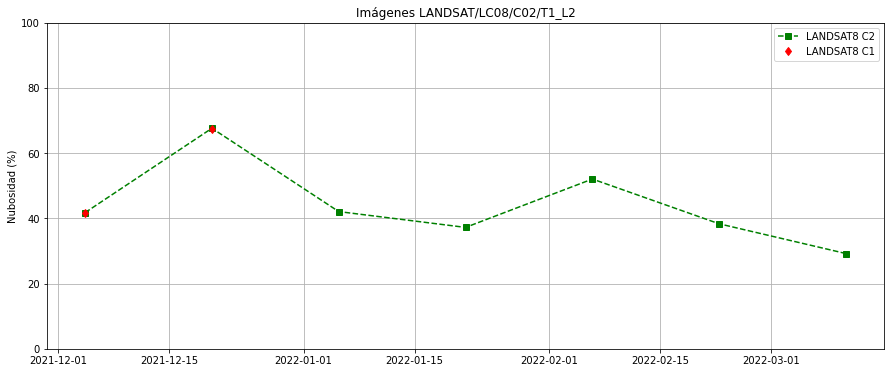

In [ ]:
# @markdown Visualización en gráfica

plt.figure(figsize=(15,6))

plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'gs--', label='LANDSAT8 C2') 
plt.plot(reporteL8_C1['Fecha Precisa'], reporteL8_C1['CLOUD_COVER'], 'rd', label='LANDSAT8 C1')

plt.title(f'Imágenes {snippet_name}')

# Eje Y
plt.ylabel('Nubosidad (%)'), plt.ylim(0,100)
#, plt.yticks([i for i in range(0,110,10)]), 

# Eje X
lista_fechas = reporteL8_c2_raw['Fecha Corta'].tolist()
fecha_start = lista_fechas[0]
fecha_end = lista_fechas[-1]

rango_fechas_x = pd.date_range(start=fecha, end=fecha_end, freq='SMS') # 'SMS' Para mostrar quincenas
plt.xticks(rango_fechas_x)#, plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

# Linea de filtrado (opcional)
# plt.axhline(10, color = 'b', linewidth = '1') # Resaltar el 0

plt.grid(), plt.legend();

In [ ]:
df_reporte = reporteL8_C2

# Visualización de imágenes por meses
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name =fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3), value=12), Output()), _dom_classes=('…

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: 2 y 18


#### USGS Landsat 8 y 9 - Histórico

In [79]:
tier = 'T1'
snippet_name = f"LANDSAT/LC08/C02/{tier}"

# Generando L9 raw

icol_l9 = (
    ee.ImageCollection(f'LANDSAT/LC09/C02/{tier}')
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL9_raw = generar_reporte(icol_l9)

# Generando L8 raw

icol_l8 = (
    ee.ImageCollection(f'LANDSAT/LC08/C02/{tier}')
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL8_c2_raw = generar_reporte(icol_l8)

# Concatenar DataFrames
df_l8_l9 = pd.concat([reporteL9_raw, reporteL8_c2_raw])

# Ordenar fechas
df_l8_l9 = df_l8_l9.sort_values('Fecha Corta') # De mayor a menor usar: ,ascending=False

# Guardar dataframe
# df_l8_l9.to_csv('df_l8_l9.csv', index=False, encoding='utf-8-sig')

df_l8_l9 = df_l8_l9.reset_index(drop=True)
df_l8_l9

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LC08/C02/T1/LC08_010065_20211204,2021-12-04 10:28:39.679,2021-12-04,2021,12,4,338,41.76,61.231303
1,LANDSAT/LC09/C02/T1/LC09_010065_20211212,2021-12-12 10:28:36.901,2021-12-12,2021,12,12,346,46.70,60.112699
2,LANDSAT/LC08/C02/T1/LC08_010065_20211220,2021-12-20 10:28:37.250,2021-12-20,2021,12,20,354,67.62,59.196546
3,LANDSAT/LC09/C02/T1/LC09_010065_20211228,2021-12-28 10:28:35.288,2021-12-28,2021,12,28,362,83.58,58.451368
4,LANDSAT/LC08/C02/T1/LC08_010065_20220105,2022-01-05 10:28:32.585,2022-01-05,2022,1,5,5,42.07,57.964139
5,LANDSAT/LC09/C02/T1/LC09_010065_20220113,2022-01-13 10:28:31.598,2022-01-13,2022,1,13,13,32.94,57.699672
6,LANDSAT/LC08/C02/T1/LC08_010065_20220121,2022-01-21 10:28:28.991,2022-01-21,2022,1,21,21,37.22,57.678164
7,LANDSAT/LC09/C02/T1/LC09_010065_20220129,2022-01-29 10:28:34.396,2022-01-29,2022,1,29,29,21.12,57.843961
8,LANDSAT/LC08/C02/T1/LC08_010065_20220206,2022-02-06 10:28:25.404,2022-02-06,2022,2,6,37,52.05,58.152624
9,LANDSAT/LC09/C02/T1/LC09_010065_20220214,2022-02-14 10:28:30.097,2022-02-14,2022,2,14,45,88.04,58.557032


In [80]:
# @markdown Visualización con Plotly

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL8_c2_raw['Fecha Precisa'], 
               y=reporteL8_c2_raw['CLOUD_COVER'],
               name='LC08/C02/T1 ', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y}%',
               line = dict(width=2)
               )
    )

fig.add_trace(
    go.Scatter(x=reporteL9_raw['Fecha Precisa'], 
               y=reporteL9_raw['CLOUD_COVER'], 
               name='LC09/C02/T1', 
               marker_color= 'blue',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y}%',
               line = dict(width=2)
              #  line = dict(width=2, dash='dot')
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Imágenes LC09/C02/T1_TOA y LC08/C02/T1'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)],
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0),
    legend=dict(x=0.4, y=-0.10),
    legend_orientation='h',
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()

In [81]:
df_reporte = df_l8_l9

# Visualizar imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name =fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3), value=12), Output()), _dom_classes=('…

#### USGS Landsat 7

##### USGS Landsat 7 Collection 2 Tier 1 TOA Reflectance  - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C02_T1_TOA)

In [ ]:
snippet_name = 'LANDSAT/LE07/C02/T1_TOA'

icol = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL7_toa = generar_reporte(icol)
reporteL7_toa

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LE07/C02/T1_TOA/LE07_010065_20211212,2021-12-12 09:17:35.031,2021-12-12,2021,12,12,346,73,44.837370
1,LANDSAT/LE07/C02/T1_TOA/LE07_010065_20211228,2021-12-28 09:16:00.837,2021-12-28,2021,12,28,362,77,42.708753
2,LANDSAT/LE07/C02/T1_TOA/LE07_010065_20220113,2022-01-13 09:14:27.589,2022-01-13,2022,1,13,13,38,41.096805
3,LANDSAT/LE07/C02/T1_TOA/LE07_010065_20220129,2022-01-29 09:12:54.678,2022-01-29,2022,1,29,29,18,40.169165


In [ ]:
# @markdown Visualización con Plotly: LANDSAT/LE07/C02/T1

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL7_toa['Fecha Precisa'], 
               y=reporteL7_toa['CLOUD_COVER'],
               name='LANDSAT/LE07/C02/T1_TOA', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = f'Imágenes {snippet_name}'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)],
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0)
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()

In [ ]:
df_reporte = reporteL7_toa

# Ver imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name=fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

In [ ]:
# @markdown Gráfica con matplotlib

# plt.figure(figsize=(17,6))

# plt.plot(reporteL7_C2['Fecha Precisa'], reporteL7_C2['CLOUD_COVER'], 'bs--', label='LANDSAT 7 C2') 
# plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'gs', label='LANDSAT 8 C2') 
# plt.plot(reporteL8_C1['Fecha Precisa'], reporteL8_C1['CLOUD_COVER'], 'rd', label='LANDSAT 8 C1')

# plt.title(f'Imágenes LANDSAT 7 y 8 - {year}')
# # Eje Y
# plt.ylabel('Nubosidad (%)'), plt.yticks([i for i in range(0,110,10)]), plt.ylim(0,100)
# # Eje X
# fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
# plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

# plt.grid(), plt.legend();

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 14, 30 (revisar)
- Setiembre: 15
- Octubre: 1, 17 (Nublado)
- Noviembre: 2 y 18


##### USGS Landsat 7 Collection 2 Tier 1 Raw Scenes  - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C02_T1)

In [ ]:
snippet_name = 'LANDSAT/LE07/C02/T1'

icol = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL7_raw = generar_reporte(icol)
reporteL7_raw

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LE07/C02/T1/LE07_010065_20080123,2008-01-23 10:18:38.585,2008-01-23,2008,1,23,23,52,55.300801
1,LANDSAT/LE07/C02/T1/LE07_010065_20080208,2008-02-08 10:18:36.098,2008-02-08,2008,2,8,39,16,55.720894
2,LANDSAT/LE07/C02/T1/LE07_010065_20080224,2008-02-24 10:18:31.741,2008-02-24,2008,2,24,55,22,56.447358


In [ ]:
# @markdown Visualización con Plotly: LANDSAT/LE07/C02/T1

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL7_raw['Fecha Precisa'], 
               y=reporteL7_raw['CLOUD_COVER'],
               name='LANDSAT/LE07/C02/T1', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = f'Imágenes {snippet_name}'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)],
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0)
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()

In [ ]:
df_reporte = reporteL7_raw

# Ver imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name=fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

#### USGS Landsat 5

USGS Landsat 5 Level 2, Collection 2, Tier 1 - [Dataset](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C02_T1_L2)

- Datos disponibles desde `1984-01-01` - `2012-05-05` lo que conlleva a máximo 4 imágenes en el año 2008.

In [ ]:
snippet_name = 'LANDSAT/LT05/C01/T1_TOA'
path = 10
row = 65

fecha = '1985-01-01'
years = 40

## Filtrado de ee.imageCollection
icol_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(ee.Date(fecha), ee.Date(fecha).advance(years, 'year'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

reporteL5_C2 = generar_reporte(icol_sr)
reporteL5_C2

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19850304,1985-03-04 09:58:44.209,1985-03-04,1985,3,4,63,10,51.986893
1,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19850928,1985-09-28 09:57:26.152,1985-09-28,1985,9,28,271,67,56.408073
2,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19860219,1986-02-19 09:54:53.138,1986-02-19,1986,2,19,50,29,50.565140
3,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19860307,1986-03-07 09:54:31.306,1986-03-07,1986,3,7,66,38,51.020065
4,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19860424,1986-04-24 09:53:30.470,1986-04-24,1986,4,24,114,24,48.742657
5,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19860915,1986-09-15 09:48:50.290,1986-09-15,1986,9,15,258,52,52.037361
6,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19861220,1986-12-20 09:47:14.750,1986-12-20,1986,12,20,354,9,50.383629
7,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19870206,1987-02-06 09:48:45.185,1987-02-06,1987,2,6,37,29,48.671631
8,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19870326,1987-03-26 09:50:34.308,1987-03-26,1987,3,26,85,34,50.083981
9,LANDSAT/LT05/C01/T1_TOA/LT05_010065_19891110,1989-11-10 09:52:43.331,1989-11-10,1989,11,10,314,72,56.427444


In [ ]:
# @markdown Visualización con Plotly

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL5_C2['Fecha Precisa'], 
               y=reporteL5_C2['CLOUD_COVER'],
               name=f'{snippet_name}', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = f'Imágenes {snippet_name}'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    # xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(years=years)],
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0)
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    # dtick='M1', 
    tickformat='%m-%Y'
    )

fig.show()

In [ ]:
df_reporte = reporteL5_C2

# Ver imágenes por mes
mes = df_reporte['Mes'].unique().tolist()

# Ojo: la función es visualizador mensual
# interact(ver_imgs_mensual, mes=mes, df=fixed(df_reporte), snippet_name=fixed(snippet_name), roi=fixed(roi));

In [ ]:
# plt.figure(figsize=(15,6))
# plt.plot(reporteL5_C2['Fecha Precisa'], reporteL5_C2['CLOUD_COVER'], 'bs--', label='LANDSAT 5 C2') 
# plt.title(f'Imágenes LANDSAT 5 - {year}'), plt.ylabel('CLOUD_COVER (%)'), plt.ylim(0,100)
# plt.grid(), plt.legend();

#### Prueba: Usando una geometría en el filtrado

In [87]:
snippet_name = 'LANDSAT/LC09/C02/T1'

icol = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterBounds(predios_agricolas)
)

reporteL9_raw = generar_reporte(icol)
reporteL9_raw

# Guardar dataframe
# reporteL8_RAW.to_csv('reporteL9_raw.csv', index=False, encoding='utf-8-sig')

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LC09/C02/T1/LC09_010064_20211212,2021-12-12 10:28:12.980,2021-12-12,2021,12,12,346,67.30,59.429429
1,LANDSAT/LC09/C02/T1/LC09_010064_20211228,2021-12-28 10:28:11.367,2021-12-28,2021,12,28,362,76.74,57.800663
2,LANDSAT/LC09/C02/T1/LC09_010064_20220113,2022-01-13 10:28:07.673,2022-01-13,2022,1,13,13,24.25,57.151377
3,LANDSAT/LC09/C02/T1/LC09_010064_20220129,2022-01-29 10:28:10.471,2022-01-29,2022,1,29,29,48.77,57.463426
4,LANDSAT/LC09/C02/T1/LC09_010064_20220214,2022-02-14 10:28:06.172,2022-02-14,2022,2,14,45,94.40,58.407489
5,LANDSAT/LC09/C02/T1/LC09_010064_20220302,2022-03-02 10:27:54.984,2022-03-02,2022,3,2,61,96.27,59.434977
6,LANDSAT/LC09/C02/T1/LC09_010065_20211212,2021-12-12 10:28:36.901,2021-12-12,2021,12,12,346,46.70,60.112699
7,LANDSAT/LC09/C02/T1/LC09_010065_20211228,2021-12-28 10:28:35.288,2021-12-28,2021,12,28,362,83.58,58.451368
8,LANDSAT/LC09/C02/T1/LC09_010065_20220113,2022-01-13 10:28:31.598,2022-01-13,2022,1,13,13,32.94,57.699672
9,LANDSAT/LC09/C02/T1/LC09_010065_20220129,2022-01-29 10:28:34.396,2022-01-29,2022,1,29,29,21.12,57.843961


Se obtienen dos grupos de imágenes al considerar dos row: 64 y 65. A continuación separaremos los dos grupos por el string que contenga los valores de path y row en los ID de las imágenes.

In [89]:
reporteL9_raw_r64 = reporteL9_raw[reporteL9_raw['ID GEE'].str.contains('LANDSAT/LC09/C02/T1/LC09_010064')].sort_values('Fecha Corta')
reporteL9_raw_r65 = reporteL9_raw[reporteL9_raw['ID GEE'].str.contains('LANDSAT/LC09/C02/T1/LC09_010065')].sort_values('Fecha Corta')

In [90]:
# @markdown Visualización con Plotly

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL9_raw_r64['Fecha Precisa'], 
               y=reporteL9_raw_r64['CLOUD_COVER'],
               name='reporteL9_raw_r64', 
               marker_color= 'blue',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

fig.add_trace(
    go.Scatter(x=reporteL9_raw_r65['Fecha Precisa'], 
               y=reporteL9_raw_r65['CLOUD_COVER'],
               name='reporteL9_raw_r65', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{x} - %{y}%'
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = f'Imágenes {snippet_name}'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x",
    title = title_plotly,
    yaxis_range = [0,100],
    xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)], 
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=50, b=25, l=0, r=0),
    legend=dict(x=0.4, y=1.10),
    legend_orientation='h',
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )
    

fig.show()

In [ ]:
# df_reporte = reporteL9_raw_r64 # Row 64
df_reporte = reporteL9_raw_r65 # Row 65

# Visualizar imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name=fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

interactive(children=(Dropdown(description='mes', options=(12, 1, 2, 3), value=12), Output()), _dom_classes=('…

### Sentinel-2

In [ ]:
# Filtrado Sentinel-2
snippet_name = 'COPERNICUS/S2_SR'

icol_s2_sr = (
    ee.ImageCollection(snippet_name)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterBounds(roi)
)

reporteS2 = generar_reporte(icol_s2_sr)
reporteS2

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,MEAN_SOLAR_ZENITH_ANGLE,CLOUDY_PIXEL_PERCENTAGE
0,COPERNICUS/S2_SR/20211202T153621_20211202T1540...,2021-12-02 10:45:07.038,2021-12-02,2021,12,2,336,25.107220,73.484620
1,COPERNICUS/S2_SR/20211207T153619_20211207T1537...,2021-12-07 10:45:02.453,2021-12-07,2021,12,7,341,25.872739,25.602575
2,COPERNICUS/S2_SR/20211212T153621_20211212T1541...,2021-12-12 10:45:06.775,2021-12-12,2021,12,12,346,26.540952,15.497769
3,COPERNICUS/S2_SR/20211217T153609_20211217T1537...,2021-12-17 10:45:01.362,2021-12-17,2021,12,17,351,27.156068,33.601699
4,COPERNICUS/S2_SR/20211222T153621_20211222T1541...,2021-12-22 10:45:08.640,2021-12-22,2021,12,22,356,27.636708,5.458303
5,COPERNICUS/S2_SR/20211227T153619_20211227T1537...,2021-12-27 10:45:03.076,2021-12-27,2021,12,27,361,28.058020,87.152607
6,COPERNICUS/S2_SR/20220101T153621_20220101T1541...,2022-01-01 10:45:09.178,2022-01-01,2022,1,1,1,28.337002,14.787443
7,COPERNICUS/S2_SR/20220106T153619_20220106T1537...,2022-01-06 10:45:03.572,2022-01-06,2022,1,6,6,28.547772,10.456863
8,COPERNICUS/S2_SR/20220111T153621_20220111T1540...,2022-01-11 10:45:08.654,2022-01-11,2022,1,11,11,28.615786,1.383118
9,COPERNICUS/S2_SR/20220116T153619_20220116T1537...,2022-01-16 10:45:03.128,2022-01-16,2022,1,16,16,28.618463,65.408037


In [ ]:
# reporteS2.to_csv('reporteS2_2021-12-2022-03.csv', index=False, encoding='utf-8-sig')

In [ ]:
# @markdown Visualización en Gráfica: Sentinel 2 y Landsat 8

plt.figure(figsize=(17, 6))
plt.plot(reporteS2['Fecha Precisa'], reporteS2['CLOUDY_PIXEL_PERCENTAGE'], 'kd--', label='SENTINEL 2')
plt.plot(reporteL8_c2_raw['Fecha Precisa'], reporteL8_c2_raw['CLOUD_COVER'], 'rs--', label='LANDSAT8 C2') 

# fechas_x = reporteL8_c2_raw['Fecha Corta'].tolist()
# nubosidad_x = reporteL8_c2_raw['CLOUD_COVER'].tolist()

# for i, v in enumerate(nubosidad_x):
#     plt.text(fechas_x[i], v-5, fechas_x[i], ha="center")

# fechas_y = reporteS2['Fecha Corta'].tolist()
# nubosidad_y = reporteS2['CLOUDY_PIXEL_PERCENTAGE'].tolist()

# for i, v in enumerate(nubosidad_y):
#     plt.text(fechas_y[i], v-5, fechas_y[i], ha="center")

plt.title(f'Imágenes Landsat 8 y Sentinel-2')

# Eje Y
plt.ylabel('Nubosidad (%)')

# plt.ylim(0,100), 
# plt.yticks([i for i in range(0,110,10)]) 

# Eje X
lista_fechas = reporteS2['Fecha Corta'].tolist()
fecha_end = reporteS2['Fecha Corta'].max()

rango_fechas_x = pd.date_range(start=fecha, end=fecha_end, freq='MS') # 'SMS' Para mostrar quincenas
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
plt.xticks(rango_fechas_x), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid(), plt.legend();

# plt.tight_layout();
# plt.savefig('prueba.jpg')

In [ ]:
# @markdown Gráfica con Plotly: Sentinel-2, Landsat 8 y Landsat 9

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteS2['Fecha Precisa'], 
               y=reporteS2['CLOUDY_PIXEL_PERCENTAGE'],
               name='Sentinel-2', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y:.2f}%',
               line = dict(width=2, dash='dot')
               )
    )

fig.add_trace(
    go.Scatter(x=reporteL9_toa['Fecha Precisa'], 
               y=reporteL9_toa['CLOUD_COVER'], 
               name='LC09/C02/T1_TOA', 
              #  marker_color= 'rgba(255,0,0, 0.7)',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y}%',
               line = dict(width=2)
               )
    )

fig.add_trace(
    go.Scatter(x=reporteL8_c2_raw['Fecha Precisa'], 
               y=reporteL8_c2_raw['CLOUD_COVER'], 
               name='LC08/C02/T1', 
              #  marker_color= 'rgba(255,0,0, 0.7)',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y}%',
               line = dict(color='royalblue', width=2)
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = 'Earth Engine - Imágenes Sentinel-2, Landsat 8 y Landsat 9 '

fig.update_layout(
    plot_bgcolor = "white",
    width = 1000,
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    # yaxis_range = [0,100],
    # xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)] 
    margin=dict(t=75, b=25, l=0, r=0),
    legend=dict(x=0.3, y=1.10),
    legend_orientation='h',
    # https://plotly.com/python/reference/layout/#layout-legend-orientation
    )

# Nombres en ejes
fig.update_yaxes(title_text='Nubosidad (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()
# fig.write_html("prueba_plotly.html")

In [ ]:
df_reporte = reporteS2

# Ver imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, mes=mes, snippet_name =fixed(snippet_name), df=fixed(df_reporte), roi=fixed(roi));

In [ ]:
# Fundo del señor Panta
# punto_fundo_panta = ee.Geometry.Point([-79.7825, -6.5969])

In [ ]:
# @markdown Visualización para Fechas 2021-2022 Chongoyape

# @markdown Nota: Debe escribirse los inputs (fechas) correctos para visualizar

plt.figure(figsize=(17, 6))

# Datos a visualizar
# plt.plot(reporteL7_C2['Fecha Precisa'], reporteL7_C2['CLOUD_COVER'], 'rs', label='LANDSAT 7 C2') 
# plt.plot(reporteL8_C2['Fecha Precisa'], reporteL8_C2['CLOUD_COVER'], 'gs', label='LANDSAT 8 C2') 
plt.plot(reporteS2['Fecha Precisa'], reporteS2['CLOUDY_PIXEL_PERCENTAGE'], 'kd', label='SENTINEL-2')
plt.plot(reporteS2['Fecha Precisa'], reporteS2['CLOUDY_PIXEL_PERCENTAGE'], 'k-.', alpha=0.5)

plt.axvline(x=pd.Timestamp('2021-8'), color='red', linestyle='--', label='Inicio 2da Campaña')

plt.title(f'Imágenes LANDSAT Y SENTINEL-2 - {year}')

# Eje Y
plt.ylabel('Nubosidad (%)'), plt.yticks([i for i in range(0,110,10)]), plt.ylim(0,100)

# Eje X
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

# Linea de filtrado (opcional)
plt.axhline(10, color = 'b', linewidth = '1') # Resaltar el 0

plt.grid(), plt.legend(bbox_to_anchor=(0.5, -0.1), ncol=4, loc="upper center");

Arroz - Campañas de siembra a cosecha: **Agosto a Diciembre**

Imágenes libre de nubes:
- Agosto: 9, 14, 19, 24
- Setiembre: 3, 13, 18 (problema de corte), 28
- Octubre: 23 y 28
- Noviembre: 2, 7, 17, 22 y 27
- Diciembre: 2


### DEM SRTM o ALOS DSM ?

Comparación de datasets DEM: SRTM vs ALOS

- [NASA SRTM Digital Elevation 30m](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) : 2000-02-11T00:00:00Z - 2000-02-22T00:00:00
- [ALOS DSM: Global 30m](https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V2_2) : 2006-01-01

In [ ]:
# Comparación entre dems: SRTM y ALOS (scale= 30m)

srtm = ee.Image("USGS/SRTMGL1_003").clip(predios_bound)
alos = ee.Image('JAXA/ALOS/AW3D30/V3_2/S007W080').select('DSM').clip(predios_bound)

# alos.date().format('YYYY-MM-dd').getInfo() # 2006-01-01

In [91]:
# Visualización
Map = geemap.Map(layer_ctrl=True)#height='800px')

vis_params_dem = {'min':30, 
                  'max':60,
                  'palette':cm.palettes.inferno_r} # Greys_r
                  
Map.centerObject(predios_agricolas, 16)

Map.addLayer(srtm, vis_params_dem, 'SRTMGL1_003 DEM')
Map.addLayer(alos, vis_params_dem, 'ALOS DSM')

Map.addLayer(predios_vis, {}, 'predios_vis')

Map.add_colorbar(vis_params_dem)
Map

Map(center=[-6.600211501838919, -79.78018963282872], controls=(WidgetControl(options=['position', 'transparent…

### Datos Meteorológicos

#### Estación Meteorológica Tinajones

In [ ]:
# Datos de estación tinajones 2021 - Descargado mensualmente y agrupado en un solo archivo alojado en GitHub
path = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/csv/Tinajones_datos_met_2021.csv'

df_tinajones = pd.read_csv(path, na_values='S/D')
df_tinajones['FECHA Larga'] = pd.to_datetime(df_tinajones['FECHA'] + ' ' + df_tinajones['HORA'], format='%d/%m/%Y %H:%M')
# df_tinajones

df_15_hr = df_tinajones[df_tinajones['HORA']=='15:00']
df_15_hr

In [ ]:
plt.figure(figsize=(15,6))

# Eje Y izquierdo
plt.plot(df_15_hr['FECHA Larga'], 
         df_15_hr['TEMPERATURA (degree C)'], 
         label='Temperatura 15:00 hrs')

plt.ylabel('Temperatura [°C]')

plt.legend(loc=4)

# Eje Y derecho: requiere reporteL8_RAW
# plt.twinx().plot(reporteL8_RAW['Fecha Precisa'], reporteL8_RAW['CLOUD_COVER'], 'kd--', label='LANDSAT8 RAW')
# plt.ylim(0,100), plt.ylabel('Nubosidad [%]')

# Eje X : Fechas
fechas_2020_2021 = pd.date_range(start='2021', end='2022', freq='MS')
plt.xticks(fechas_2020_2021), plt.gca().xaxis.set_major_formatter(date_format) # Formato '%Y-%m'

plt.grid(), plt.legend();

In [ ]:
# @markdown Gráfica con Plotly: Datos de Estación Meteorológica Tinajones

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_15_hr['FECHA Larga'], 
               y=df_15_hr['TEMPERATURA (degree C)'],
               name='Temperatura 15:00 hrs', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d/%m/%Y %H:%M",
               hovertemplate='%{y:.2f} °C',
               line = dict(width=1)
               )
    )

fig.update_traces(marker_size=5) # mode = 'markers', 

# Título y hover
title_plotly = 'Datos de Estación Meteorológica Tinajones 15:00 hrs - Temperatura'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1200,
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    # yaxis_range = [0,100],
    margin=dict(t=50, b=25, l=0, r=0)
    )

# Nombres en ejes
fig.update_yaxes(title_text='Temperatura [°C]',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()
fig.write_html("prueba_plotly.html")  

In [ ]:
# @markdown Gráfica con Plotly: Datos de Estación Meteorológica Tinajones

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_15_hr['FECHA Larga'], 
               y=df_15_hr['HUMEDAD (%)'],
               name='HUMEDAD (%) 15:00 hrs', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d/%m/%Y %H:%M",
               hovertemplate='%{y:.2f}%',
               line = dict(width=1)
               )
    )

fig.update_traces(marker_size=5) # mode = 'markers', 

# Título y hover
title_plotly = 'Datos de Estación Meteorológica Tinajones - HUMEDAD'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1200,
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    # yaxis_range = [0,100],
    margin=dict(t=50, b=25, l=0, r=0)
    )

# Nombres en ejes
fig.update_yaxes(title_text='HUMEDAD (%)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()
fig.write_html("prueba_plotly.html")

In [ ]:
# @markdown Gráfica con Plotly: Datos de Estación Meteorológica Tinajones

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_15_hr['FECHA Larga'], 
               y=df_15_hr['PRECIPITACION (mm/hora)'],
               name='PRECIPITACION 15:00 hrs', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d/%m/%Y %H:%M",
               hovertemplate='%{y:.2f} mm/hora',
               line = dict(width=1)
               )
    )

fig.update_traces(marker_size=5) # mode = 'markers', 

# Título y hover
title_plotly = 'Datos de Estación Meteorológica Tinajones - PRECIPITACION'

fig.update_layout(
    plot_bgcolor = "white",
    width = 1200,
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    # yaxis_range = [0,100],
    margin=dict(t=50, b=25, l=0, r=0)
    )

# Nombres en ejes
fig.update_yaxes(title_text='PRECIPITACION (mm/hora)',
                 showline=True, linecolor='black', mirror=True,
                 gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )

fig.show()
fig.write_html("prueba_plotly.html")

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_tinajones.FECHA, df_tinajones['PRECIPITACION (mm/hora)']);

###### Pruebas

In [ ]:
# Convertir las fechas 
from datetime import datetime
fechas = reporteL8_RAW['Fecha Corta'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
fechas

In [ ]:
for i in range(19):
  print(f"Fecha: {fechas[i]} y temperatura: {df_16_hr[ df_16_hr['FECHA'] == fechas[i] ]['TEMPERATURA (degree C)'].tolist()[0]}")

#### Estación Meteorológica INIA Vista Florida

In [ ]:
# Lectura de datos (registra cada 5 min) de la estación automática Vista Florida - Lambayeque
ruta_vf = 'https://raw.githubusercontent.com/vilcagamarracf/Inv_arroz_METRIC/main/files/csv/Vista_florida_datos_met_2021.csv'
# ruta_vf = '/content/Vista_florida_datos_met_2022_marzo.csv'

df_vf = pd.read_csv(ruta_vf,
                    encoding='latin-1',
                    skiprows=(0,1,2,3,4), 
                    skip_blank_lines=True, 
                    na_values='--',
                    decimal=','
                    )

# Columnas con fechas
df_vf['Date & Time'] = pd.to_datetime(df_vf['Date & Time'], format='%d/%m/%y %I:%M %p')

df_vf['Fecha']  = pd.DatetimeIndex(df_vf['Date & Time']).strftime('%Y-%m-%d')
df_vf['Hora']   = pd.DatetimeIndex(df_vf['Date & Time']).hour
df_vf['Minuto'] = pd.DatetimeIndex(df_vf['Date & Time']).minute

# Recorte de tabla
df_vf = df_vf[['Date & Time', 'Fecha', 'Hora', 'Minuto', 'ET - mm', 'Velocidad del viento - km/h']]

# Filtrado por fecha: Al minuto 0 se registra los valores de ET horario en la estación
# df_vf = df_vf[(df_vf['Hora'] == 10)]
df_vf = df_vf[(df_vf['Hora'] == 10) & (df_vf['Minuto'] == 0)]

# Condicion para filtrar la fecha 10 de marzo, 2022
# df_vf = df_vf[(df_vf['Fecha'] == '2022-03-10') & (df_vf['Hora'] == 10) & (df_vf['Minuto'] == 0)]

df_vf['Velocidad del viento - m/s'] = df_vf['Velocidad del viento - km/h'].apply(lambda x: round(x*10/36, 2))
df_vf

,Date & Time,Fecha,Hora,Minuto,ET - mm,Velocidad del viento - km/h,Velocidad del viento - m/s
132,2021-08-01 10:00:00,2021-08-01,10,0,0.05,0.0,0.00
420,2021-08-02 10:00:00,2021-08-02,10,0,0.05,3.2,0.89
708,2021-08-03 10:00:00,2021-08-03,10,0,0.05,NaN,NaN
996,2021-08-04 10:00:00,2021-08-04,10,0,0.05,4.8,1.33
1284,2021-08-05 10:00:00,2021-08-05,10,0,0.28,3.2,0.89
...,...,...,...,...,...,...,...
53217,2022-02-02 10:00:00,2022-02-02,10,0,0.00,NaN,NaN
53505,2022-02-03 10:00:00,2022-02-03,10,0,0.00,NaN,NaN
53793,2022-02-04 10:00:00,2022-02-04,10,0,0.48,8.0,2.22
54081,2022-02-05 10:00:00,2022-02-05,10,0,0.51,11.3,3.14


In [ ]:
# Unir con fecha 10 de marzo
# df_vf = pd.concat([df_vf, df_vf_marzo]).reset_index(drop=True)
df_vf

,Date & Time,Fecha,Hora,Minuto,ET - mm,Velocidad del viento - km/h,Velocidad del viento - m/s
0,2021-12-04 10:00:00,2021-12-04,10,0,0.30,11.3,3.14
1,2021-12-12 10:00:00,2021-12-12,10,0,0.05,0.0,0.00
2,2021-12-20 10:00:00,2021-12-20,10,0,0.08,4.8,1.33
3,2021-12-28 10:00:00,2021-12-28,10,0,0.05,4.8,1.33
4,2022-01-05 10:00:00,2022-01-05,10,0,0.05,0.0,0.00
5,2022-01-13 10:00:00,2022-01-13,10,0,0.23,6.4,1.78
6,2022-01-21 10:00:00,2022-01-21,10,0,0.28,8.0,2.22
7,2022-01-29 10:00:00,2022-01-29,10,0,0.48,12.9,3.58
8,2022-02-06 10:00:00,2022-02-06,10,0,0.48,12.9,3.58
9,2022-03-10 10:00:00,2022-03-10,10,0,0.38,3.2,0.89


In [ ]:
# Fechas en strings para filtrado de dataframe de estación
fechas_reporte_l8_l9 = df_l8_l9['Fecha Corta'].apply(lambda x: x.strftime('%Y-%m-%d')).tolist()

# Obtenemos los datos de estación meteorológica para las fechas de imágenes Landsat 8 y 9
df_vf = df_vf[df_vf['Fecha'].isin(fechas_reporte_l8_l9)].reset_index(drop=True)
df_vf

,Date & Time,Fecha,Hora,Minuto,ET - mm,Velocidad del viento - km/h,Velocidad del viento - m/s
0,2021-12-04 10:00:00,2021-12-04,10,0,0.30,11.3,3.14
1,2021-12-12 10:00:00,2021-12-12,10,0,0.05,0.0,0.00
2,2021-12-20 10:00:00,2021-12-20,10,0,0.08,4.8,1.33
3,2021-12-28 10:00:00,2021-12-28,10,0,0.05,4.8,1.33
4,2022-01-05 10:00:00,2022-01-05,10,0,0.05,0.0,0.00
5,2022-01-13 10:00:00,2022-01-13,10,0,0.23,6.4,1.78
6,2022-01-21 10:00:00,2022-01-21,10,0,0.28,8.0,2.22
7,2022-01-29 10:00:00,2022-01-29,10,0,0.48,12.9,3.58
8,2022-02-06 10:00:00,2022-02-06,10,0,0.48,12.9,3.58
9,2022-03-10 10:00:00,2022-03-10,10,0,0.38,3.2,0.89


In [ ]:
# Convertir columna de fechas a string para filtrar con el de vf
df_l8_l9['Fecha Corta'] = df_l8_l9['Fecha Corta'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
# Obtener el dataframe empatado con el de df_vf
reporte_vf = df_l8_l9[df_l8_l9['Fecha Corta'].isin(df_vf['Fecha'].tolist())].reset_index(drop=True)
reporte_vf

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION
0,LANDSAT/LC08/C02/T1/LC08_010065_20211204,2021-12-04 10:28:39.679,2021-12-04,2021,12,4,338,41.76,61.231303
1,LANDSAT/LC09/C02/T1/LC09_010065_20211212,2021-12-12 10:28:36.901,2021-12-12,2021,12,12,346,46.70,60.112699
2,LANDSAT/LC08/C02/T1/LC08_010065_20211220,2021-12-20 10:28:37.250,2021-12-20,2021,12,20,354,67.62,59.196546
3,LANDSAT/LC09/C02/T1/LC09_010065_20211228,2021-12-28 10:28:35.288,2021-12-28,2021,12,28,362,83.58,58.451368
4,LANDSAT/LC08/C02/T1/LC08_010065_20220105,2022-01-05 10:28:32.585,2022-01-05,2022,1,5,5,42.07,57.964139
5,LANDSAT/LC09/C02/T1/LC09_010065_20220113,2022-01-13 10:28:31.598,2022-01-13,2022,1,13,13,32.94,57.699672
6,LANDSAT/LC08/C02/T1/LC08_010065_20220121,2022-01-21 10:28:28.991,2022-01-21,2022,1,21,21,37.22,57.678164
7,LANDSAT/LC09/C02/T1/LC09_010065_20220129,2022-01-29 10:28:34.396,2022-01-29,2022,1,29,29,21.12,57.843961
8,LANDSAT/LC08/C02/T1/LC08_010065_20220206,2022-02-06 10:28:25.404,2022-02-06,2022,2,6,37,52.05,58.152624
9,LANDSAT/LC08/C02/T1/LC08_010065_20220310,2022-03-10 10:28:16.344,2022-03-10,2022,3,10,69,29.20,59.460507


In [ ]:
reporte_vf['ET - mm'] = df_vf['ET - mm']
reporte_vf['Velocidad del viento - m/s'] = df_vf['Velocidad del viento - m/s']
reporte_vf

,ID GEE,Fecha Precisa,Fecha Corta,Año,Mes,Día,Día Juliano,CLOUD_COVER,SUN_ELEVATION,ET - mm,Velocidad del viento - m/s
0,LANDSAT/LC08/C02/T1/LC08_010065_20211204,2021-12-04 10:28:39.679,2021-12-04,2021,12,4,338,41.76,61.231303,0.30,3.14
1,LANDSAT/LC09/C02/T1/LC09_010065_20211212,2021-12-12 10:28:36.901,2021-12-12,2021,12,12,346,46.70,60.112699,0.05,0.00
2,LANDSAT/LC08/C02/T1/LC08_010065_20211220,2021-12-20 10:28:37.250,2021-12-20,2021,12,20,354,67.62,59.196546,0.08,1.33
3,LANDSAT/LC09/C02/T1/LC09_010065_20211228,2021-12-28 10:28:35.288,2021-12-28,2021,12,28,362,83.58,58.451368,0.05,1.33
4,LANDSAT/LC08/C02/T1/LC08_010065_20220105,2022-01-05 10:28:32.585,2022-01-05,2022,1,5,5,42.07,57.964139,0.05,0.00
5,LANDSAT/LC09/C02/T1/LC09_010065_20220113,2022-01-13 10:28:31.598,2022-01-13,2022,1,13,13,32.94,57.699672,0.23,1.78
6,LANDSAT/LC08/C02/T1/LC08_010065_20220121,2022-01-21 10:28:28.991,2022-01-21,2022,1,21,21,37.22,57.678164,0.28,2.22
7,LANDSAT/LC09/C02/T1/LC09_010065_20220129,2022-01-29 10:28:34.396,2022-01-29,2022,1,29,29,21.12,57.843961,0.48,3.58
8,LANDSAT/LC08/C02/T1/LC08_010065_20220206,2022-02-06 10:28:25.404,2022-02-06,2022,2,6,37,52.05,58.152624,0.48,3.58
9,LANDSAT/LC08/C02/T1/LC08_010065_20220310,2022-03-10 10:28:16.344,2022-03-10,2022,3,10,69,29.20,59.460507,0.38,0.89


In [ ]:
# Guardar dataframe
reporte_vf.to_csv('reporte_l8_l9_estacion_vf.csv', index=False, encoding='utf-8-sig')

**Ojo**: Se desconoce el método de estimación de ET-mm que emplea la estación.
- De ser posible comparar con valores obtenidos por fórmulas empíricas para observar la variación

## Aplicaciones

### Indices de Vegetación

#### Previo
- Funciones
- Paletas de colores
- Visualizador de índices

In [ ]:
# @markdown Indices de Vegetación:
# @markdown - NDVI
# @markdown   - Función `get_ndvi_S2(image)`
# @markdown   - Función `get_ndvi_L8_C1(image)`
# @markdown   - Función `get_ndvi_L8_C2(image)`
# @markdown   - Función `get_ndvi_L7(image)`
# @markdown - EVI
# @markdown   - Función `get_evi_S2(image)`

def get_ndvi_S2(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4').divide(10000),
       'nir' : image.select('B8').divide(10000)}).rename('NDVI')
  return image.addBands(ndvi)
  
def get_ndvi_L8_C1(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('B4').divide(10000),
       'nir' : image.select('B5').divide(10000)}
       ).rename('NDVI')
  return image.addBands(ndvi)

def get_ndvi_L8_C2(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('SR_B4').multiply(0.0000275).add(-0.2),
       'nir' : image.select('SR_B5').multiply(0.0000275).add(-0.2)}
       ).rename('NDVI')
  return image.addBands(ndvi)

def get_ndvi_L7(image):
  ndvi = image.expression(
      '(nir - red) / (nir + red)',
      {'red' : image.select('SR_B3').multiply(0.0000275).add(-0.2),
       'nir' : image.select('SR_B4').multiply(0.0000275).add(-0.2)}
       ).rename('NDVI')
  return image.addBands(ndvi)

# def ndvi_icol(image):
#   ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
#   return image.addBands([ndvi])


def get_evi_S2(image):
  """
  https://developers.google.com/earth-engine/guides/image_math#expressions
  """
  evi = image.expression(
      '2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)',
      {'red' : image.select('B4').divide(10000),
       'nir' : image.select('B8').divide(10000),
       'blue': image.select('B2').divide(10000)}
       ).rename('EVI')
  return image.addBands(evi)

In [ ]:
# @markdown Paletas de colores para NDVI y EVI

#------------- Paletas de NDVI ---------------------------------------
# @markdown - `BWG` : Blue, White, Green para valores -1 a 1
BWG = ['blue', 'white', 'green']

# @markdown - `GIMMS_NDVI` : GIMMS NDVI From AVHRR Sensors (3rd Generation)
# https://developers.google.com/earth-engine/datasets/catalog/NASA_GIMMS_3GV0?hl=en
GIMMS_NDVI = ['000000', 'f5f5f5', '119701']

# @markdown - `MOD13A1` : MOD13A1.006 Terra Vegetation Indices 16-Day Global 500m
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A1?hl=en#description
MOD13A1 = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
]

# @markdown - `yuri_ndvi_pal` : Paleta NDVI (Yuri SIG) 20 Colores
yuri_ndvi_pal = [
    'ffffff', 'fffcff', 'fff9ff', 'fff7ff', 'fff4ff', 'fff2ff', 'ffefff',
    'ffecff', 'ffeaff', 'ffe7ff', 'ffe5ff', 'ffe2ff', 'ffe0ff', 'ffddff',
    'ffdaff', 'ffd8ff', 'ffd5ff', 'ffd3ff', 'ffd0ff', 'ffceff', 'ffcbff',
    'ffc8ff', 'ffc6ff', 'ffc3ff', 'ffc1ff', 'ffbeff', 'ffbcff', 'ffb9ff',
    'ffb6ff', 'ffb4ff', 'ffb1ff', 'ffafff', 'ffacff', 'ffaaff', 'ffa7ff',
    'ffa4ff', 'ffa2ff', 'ff9fff', 'ff9dff', 'ff9aff', 'ff97ff', 'ff95ff',
    'ff92ff', 'ff90ff', 'ff8dff', 'ff8bff', 'ff88ff', 'ff85ff', 'ff83ff',
    'ff80ff', 'ff7eff', 'ff7bff', 'ff79ff', 'ff76ff', 'ff73ff', 'ff71ff',
    'ff6eff', 'ff6cff', 'ff69ff', 'ff67ff', 'ff64ff', 'ff61ff', 'ff5fff',
    'ff5cff', 'ff5aff', 'ff57ff', 'ff55ff', 'ff52ff', 'ff4fff', 'ff4dff',
    'ff4aff', 'ff48ff', 'ff45ff', 'ff42ff', 'ff40ff', 'ff3dff', 'ff3bff',
    'ff38ff', 'ff36ff', 'ff33ff', 'ff30ff', 'ff2eff', 'ff2bff', 'ff29ff',
    'ff26ff', 'ff24ff', 'ff21ff', 'ff1eff', 'ff1cff', 'ff19ff', 'ff17ff',
    'ff14ff', 'ff12ff', 'ff0fff', 'ff0cff', 'ff0aff', 'ff07ff', 'ff05ff',
    'ff02ff', 'ff00ff', 'ff00ff', 'ff0af4', 'ff15e9', 'ff1fdf', 'ff2ad4',
    'ff35c9', 'ff3fbf', 'ff4ab4', 'ff55aa', 'ff5f9f', 'ff6a94', 'ff748a',
    'ff7f7f', 'ff8a74', 'ff946a', 'ff9f5f', 'ffaa55', 'ffb44a', 'ffbf3f',
    'ffc935', 'ffd42a', 'ffdf1f', 'ffe915', 'fff40a', 'ffff00', 'ffff00',
    'fffb00', 'fff700', 'fff300', 'fff000', 'ffec00', 'ffe800', 'ffe400',
    'ffe100', 'ffdd00', 'ffd900', 'ffd500', 'ffd200', 'ffce00', 'ffca00',
    'ffc600', 'ffc300', 'ffbf00', 'ffbb00', 'ffb700', 'ffb400', 'ffb000',
    'ffac00', 'ffa800', 'ffa500', 'ffa500', 'f7a400', 'f0a300', 'e8a200',
    'e1a200', 'd9a100', 'd2a000', 'ca9f00', 'c39f00', 'bb9e00', 'b49d00',
    'ac9c00', 'a59c00', '9d9b00', '969a00', '8e9900', '879900', '7f9800',
    '789700', '709700', '699600', '619500', '5a9400', '529400', '4b9300',
    '439200', '349100', '2d9000', '258f00', '1e8e00', '168e00', '0f8d00',
    '078c00', '008c00', '008c00', '008700', '008300', '007f00', '007a00',
    '007600', '007200', '006e00', '006900', '006500', '006100', '005c00',
    '005800', '005400', '005000', '004c00'
]

# @markdown - `RdYnIGn` : Paleta  para 6 rangos 0 - 0.6
RdYnIGn = ['a50026', 'f46d43', 'fee08b', 'd9ef8b', '66bd63', '006837']

#------------- Paletas de EVI ---------------------------------------
evi_palette = [
    'ffffff', 'fcd163', '99b718', '66a000', '3e8601', '207401', '056201',
    '004c00', '011301'
]

ndvi_palette = [
    "#051852", "#FFFFFF", "#C7B59B", "#A8B255", "#A3C020", "#76AD00",
    "#429001", "#006400", "#003B00", "#000000"
]

# @markdown Más paletas de colores:
# @markdown - [OpenWeather in Medium: Visualisation of the NDVI index on satellite maps. Custom palettes for agricultural applications](https://openweathermap.medium.com/visualisation-of-the-ndvi-index-on-satellite-maps-custom-palettes-for-agricultural-applications-f99b0652f991)

geemap también ofrece una gran cantidad de paletas!

In [ ]:
# @markdown Ver Indice Mensual: `ver_indice_mensual(df, indice, mes, img)`
def ver_indice_mensual(df, indice, mes, img, roi):

  lista_imgs = df['ID GEE'][df['Mes'] == mes].tolist()
  print(f'{len(lista_imgs)} imágenes en el mes')

  imagen_str = lista_imgs[img-1]
  imagen_ee = ee.Image(imagen_str)

  # if imagen_str in ['LANDSAT/LC08/C02/T1_L2', 'LANDSAT/LE07/C02/T1_L2']:
  #   imagen_rgb = imagen_ee.multiply(0.0000275).add(-0.2)
  # else: 
  #   
  imagen_rgb = imagen_ee.multiply(0.0001)

  if indice == 'ndvi':
    imagen_indice = get_ndvi_S2(imagen_ee).select(['NDVI'])
  elif indice == 'evi':
    imagen_indice = get_evi_S2(imagen_ee).select(['EVI'])
  elif indice == 'savi':
    imagen_indice = get_savi_L8(imagen_ee).select(['EVI'])

  print(f'Fecha: {mes}/{imagen_str[23:25]}')

  # Visualización
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
  viz_params = {'min':0, 'max':1, 'palette': yuri_ndvi_pal} #paleta}

  left_layer = geemap.ee_tile_layer(imagen_rgb.clip(roi), vis_rgb, 'RGB')
  right_layer = geemap.ee_tile_layer(imagen_indice.clip(roi), viz_params, indice.upper())

  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik'
  Map.split_map(left_layer, right_layer)
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)
  Map.addLayer(roi, {'color':'00FF00'}, 'Chongoyape') # roiChongoyapeDraw

  # Barra de color
  vmin = viz_params['min']
  vmax = viz_params['max']
  colors = viz_params['palette']
  Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="NDVI")
  
  return Map

Escala de NDVI y EVI: -0.2 a 1

#### NDVI

##### Sentinel-2

Para usar la herramienta Inspector es necesario solo tener una imagen visualizada. 

In [ ]:
mes = reporteS2['Mes'].unique().tolist()
interact(ver_indice_mensual, df=fixed(reporteS2), indice=['ndvi','evi'], mes=mes, img=(1,7,1), roi=fixed(chongoyape_bound));

##### Landsat

In [ ]:
# @markdown Ver Indice Mensual: `ver_indice_mensual_L8(df, indice, mes, img)`
def ver_indice_mensual_L8(df, indice, mes, img, roi):

  lista_imgs = df['ID GEE'][df['Mes'] == mes].tolist()
  print(f'{len(lista_imgs)} imágenes en el mes')

  imagen_str = lista_imgs[img-1]
  imagen_ee = ee.Image(imagen_str)
 
  imagen_rgb = imagen_ee.multiply(0.0001)

  # if indice == 'ndvi':
  imagen_indice = get_ndvi_L8_C1(imagen_ee).select(['NDVI'])
  # elif indice == 'evi':
  #   imagen_indice = get_evi_L8_C1(imagen_ee).select(['EVI'])

  print(f'Fecha: {mes}, ID: {imagen_str}')

  # Visualización
  vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 
  viz_params = {'min':0, 'max':1, 'palette': yuri_ndvi_pal} #paleta}

  left_layer = geemap.ee_tile_layer(imagen_rgb.clip(roi), vis_rgb, 'RGB')
  right_layer = geemap.ee_tile_layer(imagen_indice.clip(roi), viz_params, indice.upper())

  Map = geemap.Map(layer_ctrl=True) # basemap='OpenStreetMap.Mapnik'
  Map.centerObject(roi, 11)  # Map.setCenter(-79.809, -6.746, 9)
  Map.split_map(left_layer, right_layer)
  # Map.addLayer(imagen_rgb.clip(roi), vis_rgb, 'RGB') # roiChongoyapeDraw
  # Map.addLayer(imagen_indice.clip(roi), viz_params, indice.upper()) # roiChongoyapeDraw
  Map.addLayer(roi, {'color':'00FF00'}, 'ROI') # roiChongoyapeDraw

  # Barra de color
  vmin = viz_params['min']
  vmax = viz_params['max']
  colors = viz_params['palette']
  Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="NDVI")
  
  return Map

In [ ]:
mes = reporteL8_C1['Mes'].unique().tolist()
interact(ver_indice_mensual_L8, df=fixed(reporteL8_C1), indice=fixed('ndvi'), mes=mes, img=(1,2,1), roi=fixed(chongoyape_bound));

#### EVI

In [ ]:
interact(ver_indice_mensual, df=fixed(reporteS2), indice=['evi', 'ndvi'], mes=mes, img=(1,7,1), roi=fixed(chongoyape_bound));

### Aplicando reducciones para obtener una serie de tiempo con valores NDVI

Objetivos:
- Obtener una gráfica de valores de NDVI para la zona de evaluación a partir de imágenes Sentinel-2 SR.

  Fuente: [Time Series Visualization with Altair](https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair)

#### Funciones

In [ ]:
# @markdown Función `def create_reduce_region_function`

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326'):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [ ]:
# @markdown Función `fc_to_dict(fc)`

# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [ ]:
# @markdown Función `add_date_info(df)`

# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [ ]:
import altair as alt

#### Proceso

##### Sentinel-2

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'COPERNICUS/S2_SR'
year = 2021
# roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

# parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2
roi = chongoyape.geometry() # No olvidar que debe ser un ee.Geometry()

s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterBounds(roi)
    # .map(maskS2clouds) # Incluye el dividir por 10000
    .map(get_ndvi_S2)
    .select("NDVI")
)

###### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=roi, reducer=ee.Reducer.max(), scale=10)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

###### 3. Visualización

In [ ]:
# DataFrames NDVI: Correr dos veces para registrar ambos valores comentando uno y descomentando el otro
# df_con_mask = s2_parcelas_df.copy()
df_sin_mask = s2_parcelas_df.copy()

In [ ]:
# Visualización
plt.figure(figsize=(15,6))
plt.plot(df_sin_mask.Timestamp, df_sin_mask.NDVI, 'ks--', label='Sin Máscara')
# plt.plot(df_con_mask.Timestamp, df_con_mask.NDVI, 'b-', label='Con Máscara')

# plt.plot(dfs2['Fecha Precisa'], dfs2['Porcentaje Nubes (%)']/100, 'cs-') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}')
plt.ylabel('NDVI values'), plt.ylim(top=1)

plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(df_sin_mask).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()

In [ ]:
df_ag_dic =  s2_parcelas_df.copy()

##### Landsat 8

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'LANDSAT/LC08/C02/T1_L2'
year = 2021
roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])
path = 10
row = 65

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2

## Filtrado de ee.imageCollection
s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
    .map(get_ndvi_L8)
    .select("NDVI")
)

###### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=parcelas_chongoyape, reducer=ee.Reducer.max(), scale=30)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

###### 3. Visualización

In [ ]:
# DataFrames NDVI: Correr dos veces para registrar ambos valores comentando uno y descomentando el otro
# df_con_mask = s2_parcelas_df.copy()
# df_sin_mask = s2_parcelas_df.copy()

In [ ]:
# Visualización
plt.figure(figsize=(15,6))

# plt.plot(df_sin_mask.Timestamp, df_sin_mask.NDVI, 'ks--', label='Sin Máscara')
# plt.plot(df_con_mask.Timestamp, df_con_mask.NDVI, 'b-', label='Con Máscara')

plt.plot(s2_parcelas_df.Timestamp, s2_parcelas_df.NDVI, 'bd-', label='Landsat8')

# plt.plot(dfs2['Fecha Precisa'], dfs2['Porcentaje Nubes (%)']/100, 'cs-') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}'), plt.xlabel('Fechas'), plt.ylabel('NDVI values')
# plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
# plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
# plt.gca().xaxis.set_major_formatter(date_format)
plt.ylim(top=1)
plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(s2_parcelas_df).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()

##### Landsat 7

###### 1. Filtrado de `ee.ImageCollection`

In [ ]:
snippet_name = 'LANDSAT/LE07/C02/T1_L2'
year = 2021
roi = ee.Geometry.Point([-79.39762925890398, -6.612494380904333])
path = 10
row = 65

# lista_bandas = ['B2','B3','B4','B8'] # ['B4','B8']

parcelas_chongoyape = ee.FeatureCollection("users/CesarVilca/parcelas_chongoyape").geometry() # Abarca 1139 puntos en una imagen sentinel-2

## Filtrado de ee.imageCollection
s2 = (
    ee.ImageCollection(snippet_name)
    .filterDate(str(year), str(year+1))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
    .map(get_ndvi_L7)
    .select("NDVI")
)

###### 2. Reducciones por región

- Javier Quille comenta:
  > Sentinel-2 SR al presentar calibración atmosférica y radiométrica brinda información procesada, por ello **se toma los valores máximos de NDVI** ya que las nubes tienden a bajar el mismo.

In [ ]:
reduce_parcelas_chongoyape = create_reduce_region_function(geometry=parcelas_chongoyape, reducer=ee.Reducer.max(), scale=30)

reduce_s2 = (
    ee.FeatureCollection(s2.map(reduce_parcelas_chongoyape))
    .filter(ee.Filter.notNull(s2.first().bandNames()))
)

s2_parcelas_dict = fc_to_dict(reduce_s2).getInfo()

print(type(s2_parcelas_dict), '\n')
for prop in s2_parcelas_dict.keys():
    print(prop + ':', s2_parcelas_dict[prop][0:3] + ['...'])

In [ ]:
s2_parcelas_df = pd.DataFrame(s2_parcelas_dict)[['millis','system:index', 'NDVI']]

s2_parcelas_df = add_date_info(s2_parcelas_df)
s2_parcelas_df = s2_parcelas_df.drop(columns=['millis', 'system:index'])
s2_parcelas_df

###### 3. Visualización

In [ ]:
# Visualización
plt.figure(figsize=(15,6))

plt.plot(s2_parcelas_df.Timestamp, s2_parcelas_df.NDVI, 'kd-', label='Landsat8')
plt.plot(reporteL7_C2['Fecha Precisa'], reporteL7_C2['CLOUD_COVER']/100, 'bs-.') # Nubosidad en imágenes
plt.title(f'Serie de Tiempo: Valores de NDVI Máximos para el año {year}'), plt.ylabel('NDVI values'), plt.ylim(top=1)

plt.xlim(pd.Timestamp('2021'),pd.Timestamp('2022'))
plt.xticks([pd.Timestamp(f'2021-{i}') for i in range(1,13)]+[pd.Timestamp('2022-1')])
plt.gca().xaxis.set_major_formatter(date_format)

plt.legend(loc='lower right')
plt.axhline(0, color = 'black', linewidth = '1') # Resaltar el 0
plt.grid();

In [ ]:
# @markdown Visualización con Altair

base = alt.Chart(s2_parcelas_df).encode(x=alt.X('Timestamp:T'))

points = base.mark_circle(size=60).encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma')),
    tooltip=[
        alt.Tooltip('Timestamp:T', title='Fecha'),
        alt.Tooltip('NDVI:Q', title='NDVI')
    ])

line = base.mark_line().encode(
    y=alt.Y('NDVI:Q'),
    color=alt.Color('Year:O', scale=alt.Scale(scheme='magma'))
)

(points+line).properties(width=800, height=400).interactive()